In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-03_16-47_20200101_20200831_fixed_base.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.0022284122562674096

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

YM       0.25
NQ       0.25
GC       0.25
ES       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES      771.60
GC    10235.24
NQ    31520.40
YM    14979.40
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

57506.64000000001

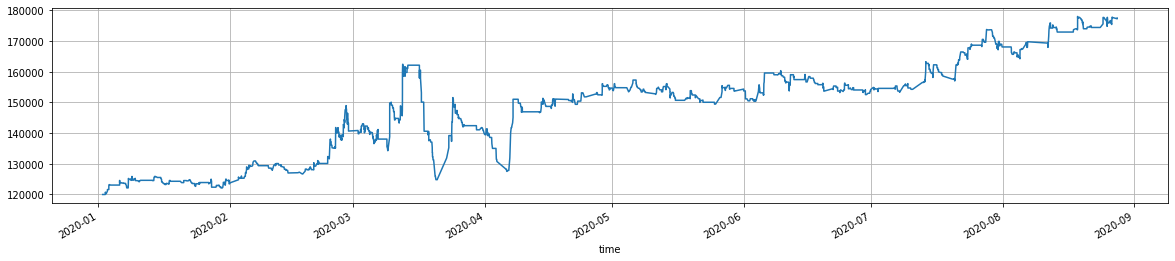

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    205
 GC    378
 NQ    976
 YM    236
 Name: action, dtype: int64,
 1795)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.191860
 GC    2.197674
 NQ    5.674419
 YM    1.372093
 Name: action, dtype: float64,
 10.436046511627907)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     430.50
GC     914.76
NQ    2049.60
YM     495.60
Name: commission, dtype: float64

In [16]:
df.commission.sum()

3890.460000000001

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.42,64.59,809.59,-484.22,1.67,59.18,488.0
GC,0.35,54.15,1211.98,-567.12,2.14,55.56,189.0
YM,0.47,126.94,1288.98,-887.53,1.45,135.43,118.0
ES,0.38,7.56,1664.39,-1018.09,1.63,1.25,102.0
total,0.41,64.11,1044.64,-614.86,1.70,65.53,897.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.035478,0.373793,0.628881,0.775401
GC,0.035478,1.000000,-0.089770,0.039837,0.417049
NQ,0.373793,-0.089770,1.000000,0.226409,0.641684
YM,0.628881,0.039837,0.226409,1.000000,0.686817
total,0.775401,0.417049,0.641684,0.686817,1.000000


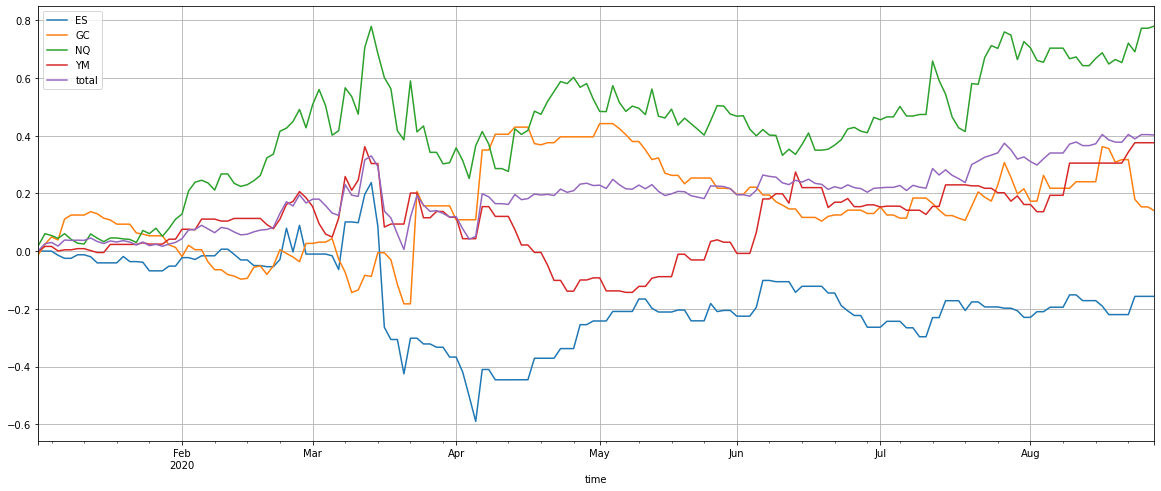

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

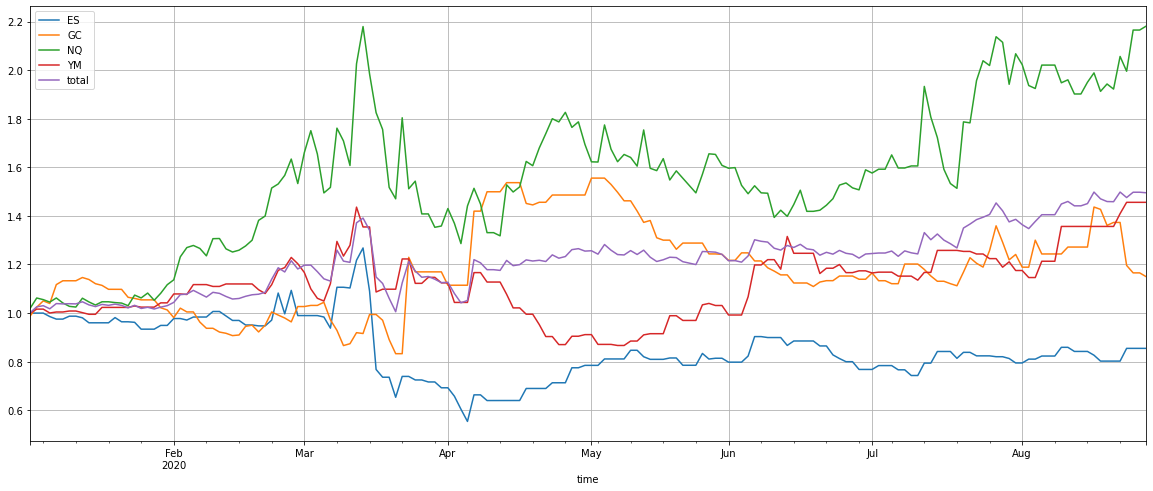

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.205316,0.226934,2.134908,0.733809,0.802815
Cumulative returns,-0.145172,0.149804,1.181188,0.455887,0.495191
Annual volatility,0.719316,0.830030,0.909032,0.604657,0.480843
Sharpe ratio,0.052387,0.602220,1.693414,1.209864,1.460177
Calmar ratio,-0.364665,0.791363,5.208956,1.850762,2.897762
Stability,0.160778,0.215272,0.602885,0.219986,0.810848
Max drawdown,-0.563027,-0.286763,-0.409853,-0.396490,-0.277046
Omega ratio,1.014156,1.186735,1.377346,1.348152,1.369608
Sortino ratio,0.074333,1.446952,3.058204,1.991321,2.685811
Skew,-0.675495,5.211713,1.161250,0.410689,1.368743


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-5.07,1.29,11.69,4.21,3.06
2020-02-29,4.27,1.39,37.27,15.45,14.64
2020-03-31,-30.03,13.89,-11.40,-6.54,-4.76
2020-04-30,13.32,27.04,24.73,-18.94,11.54
2020-05-31,3.73,-16.44,-5.09,13.15,-1.07
2020-06-30,-5.66,-8.25,-1.14,13.84,0.11
2020-07-31,3.47,8.95,30.05,0.11,11.49
2020-08-31,7.56,-7.37,5.51,23.88,7.88


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       -15.0
GC        15.0
NQ       118.0
YM        46.0
total     50.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-04-07 02:34:00,GC,SELL,1725.00,8205.16
2020-03-24 11:58:30,GC,SELL,1679.70,7985.16
2020-03-23 00:39:30,NQ,BUY,6720.25,6805.80
2020-03-12 14:57:30,ES,BUY,2556.00,6458.30
2020-03-09 14:53:00,ES,BUY,2767.00,6345.80
...,...,...,...,...
2020-03-12 17:57:00,ES,BUY,2567.50,-3354.20
2020-03-20 07:41:30,ES,BUY,2423.50,-3366.70
2020-03-16 14:55:00,ES,BUY,2449.75,-4204.20


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,0.197360,0.273505,0.050387,0.117553,0.159701
2020-03-12,0.103470,0.052021,0.260353,0.122607,0.134613
2020-03-23,0.131527,0.000000,0.226860,0.113360,0.117937
2020-03-09,0.179303,-0.044495,0.160720,0.155193,0.112681
2020-03-24,0.000000,0.476344,-0.162033,0.000000,0.078578
...,...,...,...,...,...
2020-03-16,-0.140140,0.085505,-0.089473,0.000000,-0.036027
2020-04-02,-0.050140,0.000000,-0.042640,-0.071613,-0.041098
2020-03-20,-0.112223,-0.065161,-0.030947,0.000000,-0.052083
